# Approach 2 (Specific Companies Only)

**Idea:** Get a list of O*NET occupations and their associated job titles (there are over 800 occupations and at least 5-10 titles for each). Get humans to assign each job title within and then across occupations to its likely hierarchical level in a firm, regardless of which firm it’s in. Use continuous bag of words model to expand the job titles in O*NET to the full job title list in burning glass. Once done, we can simply assign levels to each job title in BG based on coder opinion. Then we count the number of unique levels in the firm and consider firms with a larger number of unique levels as ‘more hierarchical’.

**Assumptions to test:**

Distribution of job titles within occupations: how many job titles correspond to each O*NET code from the BG data (occupation == O*NET code)  
a. For each firm, the number of occupations (unique) (BGTOcc)  
b. For every company-BGTOcc, unique number of job titles & list of those job titles. I reinterpreted this one as “For every company and every BGTOcc within it, get unique number of job titles & list of those job titles”  
c. For every job title, number of occupations it appears under  
d. Not just the # of jobs and # occupations but ideally the # of job titles matched to an occupation. How many unique job titles do you see in an occupation?  

**Additions from meeting on Friday, June 19**
1. List of job titles (consolidated & clean) e.g., for Facebook, which appear less than median (I think it was 2) times. [Link to answer](https://www.dropbox.com/s/ekqjjb4t00l8b74/fb_job_var_nums.xlsx?dl=0)
2. For a sample firm, xls with list of unique occupations (we need to read those and see whether they  make sense in terms of functions / divisions)
[Link to answer](https://www.dropbox.com/s/ccll89c1vhqf6av/sample_firm_unique_occu.csv?dl=0)
3. Avg number of occupations a job title (both consolidated & clean) is assigned to (for a sample firm and across firms in the sample) [Link to answer](https://www.dropbox.com/sh/w2j41ka4hsgx0gf/AAAdEGOsjI9_gK8__ZeVHE5Ta?dl=0)
    - For each job title in a company, how many different occupations this job map into?
    - For each of the 20 most common canon job titles, extract all unique clean job titles that correspond to them
4. Xls with examples of those job titles assigned to multiple occupations: is there an occupation they are primarily associated to, and the others are just some noise

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit, njit, vectorize
from glob import glob
import re
import seaborn as sns
import pickle
import joblib
import nltk
from collections import Counter

import concurrent.futures as cf

pd.set_option('display.max_columns', None) 

%matplotlib inline

In [2]:
dtypes={'JobID': np.str, 'CleanJobTitle': np.str, 'JobDomain': np.str, 
        'CanonCity': np.str, 'CanonCountry': np.str, 'CanonState': np.str, 
        'JobText': np.str, 'JobURL': np.str, 'PostingHTML': np.float64, 
        'Source': np.str, 'JobReferenceID': np.str, 'Email': np.str, 
        'CanonEmployer': np.str, 'Latitude': np.str, 'Longitude': np.str, 
        'CanonIntermediary': np.str, 'Telephone': np.str, 'CanonJobTitle': 'object', 
        'CanonCounty': np.str, 'DivisionCode': np.float64, 'MSA': np.str, 'LMA': np.str,
        'InternshipFlag': np.str, 'ConsolidatedONET': np.str, 'CanonCertification': np.str, 
        'CanonSkillClusters': np.str, 'CanonSkills': np.str, 'IsDuplicate': np.str, 
        'IsDuplicateOf': np.float64, 'CanonMaximumDegree': np.str, 'CanonMinimumDegree': np.str, 
        'CanonOtherDegrees': np.str, 'CanonPreferredDegrees': np.str,
        'CanonRequiredDegrees': np.str, 'CIPCode': np.str, 'StandardMajor': np.str, 
        'MaxExperience': np.float64, 'MinExperience': np.float64, 'ConsolidatedInferredNAICS': np.float64, 
        'BGTOcc': np.str, 'MaxAnnualSalary': np.float64, 'MaxHourlySalary': np.float64, 
        'MinAnnualSalary': np.float64, 'MinHourlySalary': np.float64, 'YearsOfExperience': np.str, 
        'CanonJobHours': np.str, 'CanonJobType': np.str, 'CanonPostalCode': np.str, 
        'CanonYearsOfExperienceCanonLevel': np.str, 'CanonYearsOfExperienceLevel': np.str, 
        'ConsolidatedTitle': np.str, 'Language': np.str, 'BGTSubOcc': np.str, 'JobDate': np.str,
        'ConsolidatedDegreeLevels': np.str, 'MaxDegreeLevel': np.float64, 'MinDegreeLevel': np.float64
                       }

Depending on your use case for this particular approach, you can use either of the following two lists of variables. The rest have been removed for the simple reason that they have either >90% missing or their field does not add any useful value to the dataset. For example, `PostingHTML` contains links to websites which have mostly been despricated by now.

In [3]:
best_list = ['JobID', 'CleanJobTitle', 'CanonCity', 'CanonState', 'JobDate', 'JobText', 'Source', 'CanonEmployer',
             'Latitude', 'Longitude', 'CanonIntermediary', 'CanonJobTitle', 'CanonCounty', 'DivisionCode', 'MSA', 'LMA',
             'InternshipFlag', 'ConsolidatedONET', 'CanonSkillClusters', 'CanonSkills', 'IsDuplicate', 'CanonMinimumDegree', 
             'CanonRequiredDegrees', 'CIPCode', 'MinExperience', 'ConsolidatedInferredNAICS', 'BGTOcc', 'MaxAnnualSalary',
             'MaxHourlySalary', 'MinAnnualSalary', 'MinHourlySalary', 'YearsOfExperience', 'CanonJobHours', 'CanonJobType',
             'CanonPostalCode', 'CanonYearsOfExperienceCanonLevel', 'CanonYearsOfExperienceLevel', 'ConsolidatedTitle', 
             'Language', 'BGTSubOcc', 'ConsolidatedDegreeLevels', 'MaxDegreeLevel', 'MinDegreeLevel']

This is the version used for `Approach 2`.

In [3]:
small_list = ['JobID', 'CleanJobTitle', 'JobDate', 'JobText', 'CanonEmployer', 'CanonCity', 'CanonState', 'Latitude', 'Longitude', 'CanonCounty', 
              'CanonJobTitle', 'DivisionCode', 'MSA', 'LMA', 'ConsolidatedONET', 'CanonSkillClusters', 
              'CanonSkills', 'MinExperience', 'ConsolidatedInferredNAICS', 'BGTOcc', 'CanonJobHours', 
              'CanonJobType', 'CanonYearsOfExperienceLevel', 'ConsolidatedTitle', 'BGTSubOcc'
             ]

## 1. The Data -- For multiple files use the following code

In [5]:
# Add your path a the wildcard * to select multiple files with glob

files = glob('/Users/ramonperez/Dropbox/Burning Glass/Analysis/company_data/x_co*.csv') 
files[:3]

['/Users/ramonperez/Dropbox/Burning Glass/Analysis/company_data/x_companies_2.csv',
 '/Users/ramonperez/Dropbox/Burning Glass/Analysis/company_data/x_companies_3.csv',
 '/Users/ramonperez/Dropbox/Burning Glass/Analysis/company_data/x_companies_1.csv']

#### One approach is to read the data with a list comprehension

This is fine for 1 to 3 GB of data that fits into memory.

In [28]:
%%time

# Create a list containing all of the datasets
dfs = [pd.read_csv(f, low_memory=False, parse_dates=['JobDate'], usecols=small_list, dtype=dtypes) for f in files]

# Concatenate all of the datasets into one
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df.head(3)

CPU times: user 28.5 s, sys: 27.2 s, total: 55.7 s
Wall time: 1min 52s


#### The other approach is to take advantage of multiprocessing

This is great for 2 or more GB of data. Keep in mind that the size of the data you will read should be less than your RAM.

In [6]:
%%time


def get_data(data):
    return pd.read_csv(data, low_memory=False,
                       parse_dates=['JobDate'], 
                       usecols=small_list, dtype=dtypes)

with cf.ProcessPoolExecutor() as executor:
    results = executor.map(get_data, files)
    
df = pd.concat(results)
df.reset_index(drop=True, inplace=True)
df.head(3)

CPU times: user 9.24 s, sys: 39.6 s, total: 48.8 s
Wall time: 3min 53s


,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience
0,41-2031.00,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN
1,41-2031.00,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN
2,53-7061.00,Detailer,Fowlerville,Livingston,Chrysler,fulltime,Automotive Detailer,permanent,Specialized Skills|Specialized Skills,{'Automotive Services Industry Knowledge': 'Sp...,MI,NaN,Automotive Service Detailer,336111.0,53706100,Automotive Detailer,47664.0,2017-03-20,38198645467,Automotive Service Detailer\n\nChrysler Dealer...,DV264764|MT261982,42.6645,-84.0695,19820: Metropolitan Statistical Area|220: Comb...,NaN


In [7]:
df.head(3)

,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience
0,41-2031.00,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN
1,41-2031.00,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN
2,53-7061.00,Detailer,Fowlerville,Livingston,Chrysler,fulltime,Automotive Detailer,permanent,Specialized Skills|Specialized Skills,{'Automotive Services Industry Knowledge': 'Sp...,MI,NaN,Automotive Service Detailer,336111.0,53706100,Automotive Detailer,47664.0,2017-03-20,38198645467,Automotive Service Detailer\n\nChrysler Dealer...,DV264764|MT261982,42.6645,-84.0695,19820: Metropolitan Statistical Area|220: Comb...,NaN


In [8]:
df.shape

(718629, 25)

We will normalise the Employer names a bit in this dataset in a manual way by mapping the clean names to the not so clean ones. **NB**: This would not be a good approach to the larger dataset.

In [11]:
dict_comps = {
    'Chrysler':'Chrysler',
    'Ford Motor Company':'Ford Motor Company', 
    'JP Morgan Chase Company':'JP Morgan Chase Company', 
    'McKinsey & Company':'McKinsey & Company',
    'Boston Consulting Group Incorporated':'Boston Consulting Group',
    'Boston Consulting Group':'Boston Consulting Group',
    'Bain Company':'Bain Company',
    'Bain Company Incorporated':'Bain Company',
    'General Motors':'General Motors',
    'Microsoft Corporation':'Microsoft Corporation',
    'Citi':'Citi',
    'PepsiCo Inc.':'PepsiCo Inc.',
    'Tyson Foods Incorporated':'Tyson Foods Incorporated',
    'Nestle USA Incorporated':'Nestle USA Incorporated',
    'Bank of America':'Bank of America',
    'The Goldman Sachs Group, Inc.':'The Goldman Sachs Group, Inc.',
    'Morgan Stanley':'Morgan Stanley',
    'Kraft Foods':'Kraft Foods',
    'Anheuser-Busch Companies, Inc.':'Anheuser-Busch Companies, Inc.',
    'Google Inc.':'Google Inc.',
    'Facebook':'Facebook',
    'Twitter':'Twitter',
    'Yahoo':'Yahoo',
    'Chryslerdealer':'Chrysler',
    'Oliver Wyman':'Oliver Wyman',
    'Oliver Wyman, Inc':'Oliver Wyman',
    'Bank Of America Charlotte':'Bank of America',
    'Roland Berger':'Roland Berger',
    'Roland Berger Llc':'Roland Berger',
    'General Motorsgeneral Motors':'General Motors',
    'Facebookadvertisers':'Facebook'
}

In [10]:
df['CanonEmployer'] = df['CanonEmployer'].map(dict_comps)

Let's now take out any observation without a job description.

In [12]:
%%time

df = df[df['JobText'].notna()].copy()

CPU times: user 2.27 s, sys: 8.86 s, total: 11.1 s
Wall time: 20.8 s


Check out the space that is currently occupied in your computer's memory with the following command.

In [13]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718301 entries, 0 to 718628
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   BGTOcc                       645891 non-null  object        
 1   BGTSubOcc                    645870 non-null  object        
 2   CanonCity                    711832 non-null  object        
 3   CanonCounty                  709999 non-null  object        
 4   CanonEmployer                718301 non-null  object        
 5   CanonJobHours                396003 non-null  object        
 6   CanonJobTitle                410256 non-null  object        
 7   CanonJobType                 397617 non-null  object        
 8   CanonSkillClusters           707773 non-null  object        
 9   CanonSkills                  718301 non-null  object        
 10  CanonState                   718283 non-null  object        
 11  CanonYearsOfExperienceLeve

In [14]:
missing_vals = df.isnull().sum() / df.shape[0] * 100
missing_vals

BGTOcc                         10.080732
BGTSubOcc                      10.083656
CanonCity                       0.900597
CanonCounty                     1.155783
CanonEmployer                   0.000000
CanonJobHours                  44.869491
CanonJobTitle                  42.885225
CanonJobType                   44.644794
CanonSkillClusters              1.465681
CanonSkills                     0.000000
CanonState                      0.002506
CanonYearsOfExperienceLevel    36.499323
CleanJobTitle                   0.012530
ConsolidatedInferredNAICS       0.633996
ConsolidatedONET                5.727961
ConsolidatedTitle               0.005569
DivisionCode                   46.570867
JobDate                         0.000000
JobID                           0.000000
JobText                         0.000000
LMA                             1.487956
Latitude                        0.898091
Longitude                       0.898091
MSA                             2.643321
MinExperience   

Notice that some vars above have a high percentage of missing values. If you would like to get rid of some of them given a threshold, change the value 70 below to your desired threshold.

In [15]:
to_drop = (missing_vals[missing_vals > 70]).index
df.drop(to_drop, axis=1, inplace=True)
df.head(3)

,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience
0,41-2031.00,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN
1,41-2031.00,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN
2,53-7061.00,Detailer,Fowlerville,Livingston,Chrysler,fulltime,Automotive Detailer,permanent,Specialized Skills|Specialized Skills,{'Automotive Services Industry Knowledge': 'Sp...,MI,NaN,Automotive Service Detailer,336111.0,53706100,Automotive Detailer,47664.0,2017-03-20,38198645467,Automotive Service Detailer\n\nChrysler Dealer...,DV264764|MT261982,42.6645,-84.0695,19820: Metropolitan Statistical Area|220: Comb...,NaN


Let's inspect the amount of occupations found in each company before moving to the next section.

In [16]:
companies = df.groupby(['CanonEmployer'])

In [17]:
companies[['BGTOcc','ConsolidatedInferredNAICS', 'ConsolidatedONET']].agg(['count'])

,BGTOcc,ConsolidatedInferredNAICS,ConsolidatedONET
,count,count,count
CanonEmployer,,,
"Anheuser-Busch Companies, Inc.",4298,5005,4703
Bain Company,1013,520,1057
Bank of America,128493,147389,138164
Boston Consulting Group,1765,767,2030
Chrysler,48776,50877,50150
Citi,42399,47884,44461
Facebook,23208,25818,24491
Ford Motor Company,9564,10628,9986


The `BTGOcc` var contains values with a `-` in them so we will filtered `NaN` values out, remove the `-`, and change the data type to `int8` for our mergin purposes coming up in the next section.

In [18]:
df['BGTOcc'].str.replace('-', '').astype(np.float32).isna().sum()

72410

In [19]:
%%time

df = df[df['BGTOcc'].notna()].copy()
df['BGTOcc'] = df['BGTOcc'].str.replace('-', '').astype(np.float32).astype(np.int32)
df['BGTOcc'].head()

CPU times: user 1.03 s, sys: 1.7 s, total: 2.73 s
Wall time: 2.88 s


0    412031
1    412031
2    537061
3    419041
4    493023
Name: BGTOcc, dtype: int32

## 2. Load Occupations Data

You can find the cleaned occupations data in our collaborative [DropBox folder here](https://www.dropbox.com/sh/k3qogf35dhxepik/AADndlDA4VZcLl5Mku0wAFRFa?dl=0).

In [21]:
occupations_df = pd.read_csv('~/Dropbox/Burning Glass/Analysis/occupations_clean.csv',
                             dtype={'occu_code': np.int32, 'occu_text': np.str})
occupations_df.head()

,occu_code,occu_text
0,110000,Management Occupations
1,112022,Sales Managers
2,113021,Computer and Information Systems Managers
3,113131,Training and Development Managers
4,119021,Construction Managers


In [22]:
occupations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   occu_code  564 non-null    int32 
 1   occu_text  564 non-null    object
dtypes: int32(1), object(1)
memory usage: 6.7+ KB


In [23]:
df.shape

(645891, 25)

We will merge the the main dataframe with the occupations dataframe using an inner join, and by combining `BTGOcc` with `occu_code` (which stands for occupation code).

In [24]:
%%time

new_df = df.merge(occupations_df, 
                  left_on='BGTOcc', 
                  right_on='occu_code', 
                  how='inner')
new_df.head()

CPU times: user 1.72 s, sys: 1.59 s, total: 3.31 s
Wall time: 3.35 s


,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience,occu_code,occu_text
0,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons
1,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons
2,412031,Retail Sales Associate (General),Arlington Heights,Cook,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,IL,mid,Automotive Sales Associate,336111.0,41203100,Sales Associate,16974.0,2017-03-13,38195316884,Automotive Sales Associate\n\nArlington Height...,DV171697|MT171698,41.8792,-87.9747,16980: Metropolitan Statistical Area|176: Comb...,3.0,412031,Retail Salespersons
3,412031,Retail Sales Associate (General),Elgin,Kane,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,IL,mid,Automotive Sales Associate,336111.0,41203100,Sales Associate,20994.0,2017-03-13,38195337619,"Automotive Sales Associate\n\nElgin, Illinois ...",DV171697|MT171698,42.0363,-88.2398,16980: Metropolitan Statistical Area|176: Comb...,3.0,412031,Retail Salespersons
4,412031,Retail Sales Associate (General),Cincinnati,Hamilton,Chrysler,fulltime,NaN,permanent,Supply Chain and Logistics: Procurement;Specia...,{'Buying Experience': 'Supply Chain and Logist...,OH,NaN,Automobile Sales & Used,336111.0,41203100,Automobile Sales,NaN,2017-03-14,38195661888,Automobile Sales NEW & USED\n\nJake Sweeney Ch...,MT391714,39.1072,-84.5003,17140: Metropolitan Statistical Area,NaN,412031,Retail Salespersons


Inspect the new dataframe shape.

In [25]:
new_df.shape

(540143, 27)

### Amount of Occupations per Employer on Filtered Down Data

In [26]:
companies = new_df.groupby(['CanonEmployer'])
companies['occu_text'].agg(['count'])

,count
CanonEmployer,
"Anheuser-Busch Companies, Inc.",3632
Bain Company,875
Bank of America,102030
Boston Consulting Group,1405
Chrysler,46804
Citi,34659
Facebook,17455
Ford Motor Company,8728
General Motors,25734


Let's save the final dataset and move on to the testing all assumptions.

In [26]:
new_df.to_csv('~/Dropbox/Burning Glass/Data/comps_occupations_merged.csv', 
              index=False)

## 3. Load Merged Dataset

To release some memory from your PC, make sure you restart the kernel (if on Jupyter Notebooks), load the libraries we will need, and proceed to run the code below.

If you come back to this notebook and start from this section onwards, don't forget to load all of the libraries we will use, which can be found at the beginning of this notebook.

In [4]:
%%time

df = pd.read_csv('~/Dropbox/Burning Glass/Data/comps_occupations_merged.csv',
                 low_memory=False, parse_dates=['JobDate'], dtype=dtypes)

# Concatenate all of the datasets into one
df.reset_index(drop=True, inplace=True)
df.head(3)

CPU times: user 20.9 s, sys: 13 s, total: 33.9 s
Wall time: 44.5 s


,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience,occu_code,occu_text
0,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons
1,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons
2,412031,Retail Sales Associate (General),Arlington Heights,Cook,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,IL,mid,Automotive Sales Associate,336111.0,41203100,Sales Associate,16974.0,2017-03-13,38195316884,Automotive Sales Associate\n\nArlington Height...,DV171697|MT171698,41.8792,-87.9747,16980: Metropolitan Statistical Area|176: Comb...,3.0,412031,Retail Salespersons


We will define a path for saving the output of all assumptions in approach 2 below.

In [88]:
!ls ~/Dropbox

Burning Glass                      Icon?
ExtendedChapter9.pdf               compressed_df.pkl
Get Started with Dropbox Paper.url new_df.csv
Get Started with Dropbox.pdf


In [89]:
path_assumptions = '/Users/ramonperez/Dropbox/Burning Glass/Analysis/approach_2/'

Let's look at the memory usage of our new merged dataset.

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540143 entries, 0 to 540142
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   BGTOcc                       540143 non-null  object        
 1   BGTSubOcc                    540122 non-null  object        
 2   CanonCity                    535037 non-null  object        
 3   CanonCounty                  533867 non-null  object        
 4   CanonEmployer                540143 non-null  object        
 5   CanonJobHours                303355 non-null  object        
 6   CanonJobTitle                366347 non-null  object        
 7   CanonJobType                 304541 non-null  object        
 8   CanonSkillClusters           532116 non-null  object        
 9   CanonSkills                  540143 non-null  object        
 10  CanonState                   540126 non-null  object        
 11  CanonYearsOfExperienceLeve

# 4. Test Assumptions

## a. For each firm, what is the number of unique occupations?

We will first take a list of the unique companies in the dataset.

In [8]:
comps = list(df['CanonEmployer'].unique())
comps

['Chrysler',
 'Ford Motor Company',
 'JP Morgan Chase Company',
 'McKinsey & Company',
 'Boston Consulting Group',
 'Bain Company',
 'General Motors',
 'Microsoft Corporation',
 'Citi',
 'PepsiCo Inc.',
 'Tyson Foods Incorporated',
 'Nestle USA Incorporated',
 'Bank of America',
 'The Goldman Sachs Group, Inc.',
 'Morgan Stanley',
 'Kraft Foods',
 'Anheuser-Busch Companies, Inc.',
 'Google Inc.',
 'Facebook',
 'Twitter',
 'Yahoo',
 'Oliver Wyman',
 'Roland Berger']

Then, we will iterate over the list of employers, add the name of the employer and the number of unique occupations as key-value pairs to a dictionary, and then add the employer's name and the name of the unique occupations to another dictionary. In essence, we are creating two dictionaries:
- One with the employers and the amount of occupations advertised between 2016 and 2018
- Another with the employer and the name of those occupations for which they advertised roles between 2016 and 2018

In [9]:
%%time

unique_occ_comp = {}
unique_occ_nums = {}

for comp in comps:
    unique_occs = list(df.loc[df['CanonEmployer'] == comp, 'occu_text'].unique())
    number_occs = len(df.loc[df['CanonEmployer'] == comp, 'occu_text'].unique())
    unique_occ_comp[comp] = unique_occs
    unique_occ_nums[comp] = number_occs

CPU times: user 1.21 s, sys: 39.4 ms, total: 1.25 s
Wall time: 1.3 s


Let's evaluate the results of the amount of unique occupations per firm.

In [10]:
from pprint import pprint
pprint(unique_occ_nums)

{'Anheuser-Busch Companies, Inc.': 137,
 'Bain Company': 55,
 'Bank of America': 227,
 'Boston Consulting Group': 81,
 'Chrysler': 254,
 'Citi': 197,
 'Facebook': 247,
 'Ford Motor Company': 155,
 'General Motors': 241,
 'Google Inc.': 170,
 'JP Morgan Chase Company': 242,
 'Kraft Foods': 123,
 'McKinsey & Company': 116,
 'Microsoft Corporation': 210,
 'Morgan Stanley': 134,
 'Nestle USA Incorporated': 209,
 'Oliver Wyman': 30,
 'PepsiCo Inc.': 214,
 'Roland Berger': 4,
 'The Goldman Sachs Group, Inc.': 154,
 'Twitter': 138,
 'Tyson Foods Incorporated': 206,
 'Yahoo': 90}


Let' now visualise those values by converting our dictionary into a pandas series and calling the pandas method `.plot()` on it.

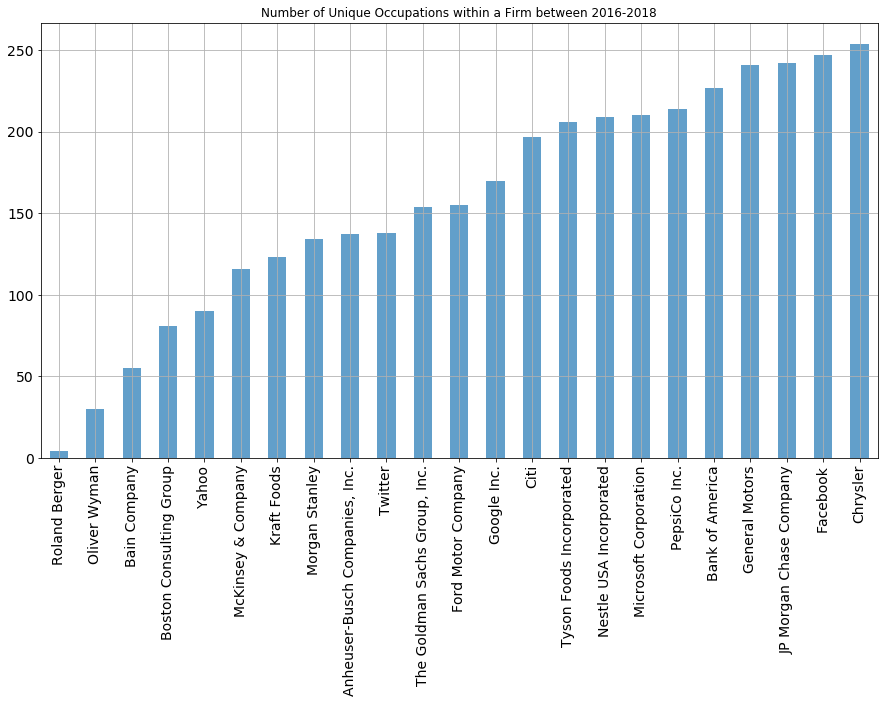

In [11]:
pd.Series(unique_occ_nums).sort_values().plot(kind='bar',
                                              rot=90, 
                                              figsize=(15, 8),
                                              fontsize=14,
                                              title='Number of Unique Occupations within a Firm between 2016-2018',
                                              grid=True,
                                              alpha=0.70);

Let's now look at the name of those unique occupations within a firm.

In [125]:
pprint(unique_occ_comp['Kraft Foods'][:10])

['Retail Salespersons',
 'Cleaners of Vehicles and Equipment',
 'Automotive Service Technicians and Mechanics',
 'Sales Representatives, Wholesale and Manufacturing, Technical and Scientific '
 'Products',
 'Secretaries and Administrative Assistants, Except Legal, Medical, and '
 'Executive',
 'Light Truck or Delivery Services Drivers',
 'First-Line Supervisors of Mechanics, Installers, and Repairers',
 'Computer Programmers',
 'Accountants and Auditors',
 'Computer Occupations, All Other']


Let's save both samples to a csv file for a more in-depth evaluation.

In [24]:
# unique occupation counts
pd.Series(unique_occ_nums).to_csv(path_assumptions + 'unique_occu_nums_per_firms.csv')

# unique occupation names
(pd.DataFrame.from_dict(unique_occ_comp, orient='index')
             .T
             .to_csv(path_assumptions + 'unique_occu_names_per_firms.csv', index=False))

## b. For every occupation within a company, get the unique number of job titles & names of those job titles

We will add all three columns to a variable called job_cols as it will be easier to use them later on.

In [13]:
job_cols = ['CleanJobTitle', 'ConsolidatedTitle', 'CanonJobTitle']

To get the name of the jobs within each occupation at a company, we can move the variables of interest to the index and create a multi-level index. Then we select our columns above to make each job map to the companies and occupations. The next step will be to reset the index to get those columns out and repopulate the matching values to each job.

In [200]:
# set the columns of interest in a multilevel index, this can also be thought of as
# adding dimensions to our dataset
comps_occus = df.set_index(['CanonEmployer', 'occu_text'])

# select the job title columns and bring the companies and occupations back out
comps_occus = comps_occus[job_cols].reset_index()
comps_occus.head()

CPU times: user 358 ms, sys: 120 ms, total: 478 ms
Wall time: 557 ms


,CanonEmployer,occu_text,CleanJobTitle,ConsolidatedTitle,CanonJobTitle
0,Chrysler,Retail Salespersons,Sales Associate,Sales Associate,Sales Associate
1,Chrysler,Retail Salespersons,Automotive Sales Associate,Sales Associate,Sales Associate
2,Chrysler,Retail Salespersons,Automotive Sales Associate,Sales Associate,Sales Associate
3,Chrysler,Retail Salespersons,Automotive Sales Associate,Sales Associate,Sales Associate
4,Chrysler,Retail Salespersons,Automobile Sales & Used,Automobile Sales,NaN


In [201]:
# evaluate the shape of the dataset containing duplicates
comps_occus.shape

(540143, 5)

Now that we have the dataset we wanted for this assumption, we can go ahead and get rid of duplicates with the `.drop_duplicates()` method of pandas.

In [208]:
comps_occus.drop_duplicates(inplace=True)
comps_occus.head()

,CanonEmployer,occu_text,CleanJobTitle,ConsolidatedTitle,CanonJobTitle
0,Chrysler,Retail Salespersons,Sales Associate,Sales Associate,Sales Associate
1,Chrysler,Retail Salespersons,Automotive Sales Associate,Sales Associate,Sales Associate
4,Chrysler,Retail Salespersons,Automobile Sales & Used,Automobile Sales,NaN
5,Chrysler,Retail Salespersons,Automobile Sales - Internet,Automobile Sales/Intern,NaN
6,Chrysler,Retail Salespersons,Internet Sales/Bdc Sales/Automotive Sales,"Intern/Sales, Sales,Automotive Sales",NaN


In [209]:
# notice the new shape of the dataset
comps_occus.shape

(216517, 5)

To get the number of unique jobs we will group again our dataset by company and occupation, select the job title columns, and then apply the `.count()` method to the unique count of each.

In [211]:
comps_occus_nums = comps_occus.groupby(['CanonEmployer', 'occu_text'])[job_cols].count()
comps_occus_nums.head()

CleanJobTitle  \
CanonEmployer                  occu_text                                                  
Anheuser-Busch Companies, Inc. Accountants and Auditors                              69   
                               Agricultural and Food Science Technicians              2   
                               Amusement and Recreation Attendants                    2   
                               Architects, Except Landscape and Naval                 3   
                               Archivists                                             1   

                                                                          ConsolidatedTitle  \
CanonEmployer                  occu_text                                                      
Anheuser-Busch Companies, Inc. Accountants and Auditors                                  69   
                               Agricultural and Food Science Technicians                  2   
                               Amusement and Recreation Attendants                        2   
                               Architects, Except Landscape and Naval                     3   
                               Archivists                                                 1   

                                                                          CanonJobTitle  
CanonEmployer                  occu_text                                                 
Anheuser-Busch Companies, Inc. Accountants and Auditors                              60  
                               Agricultural and Food Science Technicians              0  
                               Amusement and Recreation Attendants                    0  
                               Architects, Except Landscape and Naval                 0  
                               Archivists                                             0

Let's save both files to our shared [Dropbox folder > Burning Glass > Analysis > approach_2 > part_b](https://www.dropbox.com/sh/faunias0nig1mya/AACc4bmAKqQHRWbvnawseCjea?dl=0).

In [212]:
%%time

comps_occus.to_csv(path_assumptions + 'comps_occus_jobs_names.csv', index=False)
comps_occus_nums.to_csv(path_assumptions + 'comps_occus_jobs_nums.csv')

CPU times: user 828 ms, sys: 130 ms, total: 959 ms
Wall time: 1.06 s


# c. For every job title, number of occupations it appears under

Here is the column var we created a bit ago. We will use it again to get the data we need.

In [39]:
job_cols

['CleanJobTitle', 'ConsolidatedTitle', 'CanonJobTitle']

In [40]:
CleanJobTitle = [x for x in list(df['CleanJobTitle'].unique()) if str(x) != 'nan']
ConsolidatedTitle = [x for x in list(df['ConsolidatedTitle'].unique()) if str(x) != 'nan']
CanonJobTitle = [x for x in list(df['CanonJobTitle'].unique()) if str(x) != 'nan']
CleanJobTitle[:2], ConsolidatedTitle[:2], CanonJobTitle[:2]

(['Sales Associate', 'Automotive Sales Associate'],
 ['Sales Associate', 'Automobile Sales'],
 ['Sales Associate', 'Sales Representative'])

In [41]:
len(CleanJobTitle), len(ConsolidatedTitle), len(CanonJobTitle)

(207310, 54487, 2278)

The numbers above are the amount of unique jobs per job title variable (without any missing values).

We will now create groups of all variables of interest and add the count of the amount of occupations in which a job title appears in.

### Number of Occupations in Which at Job in CanonJobTitle Appears

In [91]:
occu_per_title_CanonJobTitle = df.groupby(['CanonEmployer', 'CanonJobTitle'])
occu_per_title_CanonJobTitle = occu_per_title_CanonJobTitle['occu_text'].count().reset_index()
occu_per_title_CanonJobTitle.head()

,CanonEmployer,CanonJobTitle,occu_text
0,"Anheuser-Busch Companies, Inc.",Account Manager,141
1,"Anheuser-Busch Companies, Inc.",Accountant,8
2,"Anheuser-Busch Companies, Inc.",Accounting Analyst,1
3,"Anheuser-Busch Companies, Inc.",Accounting Assistant,14
4,"Anheuser-Busch Companies, Inc.",Accounting Clerk,31


### Number of Occupations in Which at Job in ConsolidatedTitle Appears

In [92]:
occu_per_title_ConsolidatedTitle = df.groupby(['CanonEmployer', 'ConsolidatedTitle'])
occu_per_title_ConsolidatedTitle = occu_per_title_ConsolidatedTitle['occu_text'].count().reset_index()
occu_per_title_ConsolidatedTitle.head()

,CanonEmployer,ConsolidatedTitle,occu_text
0,"Anheuser-Busch Companies, Inc.",2018 Ab Inbev Gmt Scholarship,1
1,"Anheuser-Busch Companies, Inc.",Ab Inbev Gmt Scholarship,1
2,"Anheuser-Busch Companies, Inc.","Ab, Event Services",1
3,"Anheuser-Busch Companies, Inc.",Account Manager,141
4,"Anheuser-Busch Companies, Inc.",Accountant,8


### Number of Occupations in Which at Job in CleanJobTitle Appears

In [93]:
occu_per_title_CleanJobTitle = df.groupby(['CanonEmployer', 'CleanJobTitle'])
occu_per_title_CleanJobTitle = occu_per_title_CleanJobTitle['occu_text'].count().reset_index()
occu_per_title_CleanJobTitle.head()

,CanonEmployer,CleanJobTitle,occu_text
0,"Anheuser-Busch Companies, Inc.",2016 Brewery Experiences Team Member,2
1,"Anheuser-Busch Companies, Inc.",2017 Summer Brewery Experiences Team Member,1
2,"Anheuser-Busch Companies, Inc.",2017 Summer Gift Shop Team Member,1
3,"Anheuser-Busch Companies, Inc.",2017 Summer Tour Team Member,1
4,"Anheuser-Busch Companies, Inc.",2018 Ab Inbev Gmt Scholarship,1


Let's save all files as an Excel file with different sheets into our shared [Dropbox folder > Burning Glass > Analysis > approach_2 > part_c](https://www.dropbox.com/sh/gygve96olza6d31/AACoqU-5uwe56BSrQvw7h8tza?dl=0).

In [95]:
%%time

writer = pd.ExcelWriter(path_assumptions + 'allcompanies_job_occu_nums.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
jobs_per_occu.to_excel(writer, sheet_name='jobs_per_occu', index=False)
occu_per_title_CleanJobTitle.to_excel(writer, sheet_name='CleanJobTitle', index=False)
occu_per_title_ConsolidatedTitle.to_excel(writer, sheet_name='ConsolidatedTitle', index=False)
occu_per_title_CanonJobTitle.to_excel(writer, sheet_name='CanonJobTitle', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

CPU times: user 14.2 s, sys: 332 ms, total: 14.5 s
Wall time: 14.7 s


In [96]:
occu_per_title_CleanJobTitle[occu_per_title_CleanJobTitle['CanonEmployer'] == 'Facebook'].head()

,CanonEmployer,CleanJobTitle,occu_text
66610,Facebook,.Net Consultant,1
66611,Facebook,.Net Developer,4
66612,Facebook,.Net Web Developer,1
66613,Facebook,0005 Behavioral Health Registered Nurse,1
66614,Facebook,10-$15/Hour Summer Job 40 Hr/Week House Painti...,1


# d. Avg number of occupations a job title is assigned to

What we will do in this section to get the average number of occupations a job title is assigned to is to, create groups of titles and occupations, assign the n count of an occupation back into the groupped dataframe, reset the index of the groupped dataframe, and then re-group the dataset to take the mean of the n count of the different instances of occupations. A mouthfull, I know 😅, so let's look at the code instead.

## CanonJobTitle

In [117]:
# first group the dataset by job title var and occupation
group_CanonJobTitle = df.groupby(['CanonJobTitle', 'occu_text'])

# get the ammount of occupations within that job title var using the aggregation function count
testing = group_CanonJobTitle['occu_text'].agg('count')

# reset the index twice, first to rename our column of interest and then to fully reset the df
df_CanonJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()

# examine the dataset
df_CanonJobTitle.head()

,CanonJobTitle,occu_text,occu_count
0,.Net Application Developer,Computer Programmers,53
1,.Net Application Developer,Computer User Support Specialists,1
2,.Net Application Developer,Web Developers,2
3,.Net Architect,"Computer Occupations, All Other",1
4,.Net Architect,Computer Programmers,4


In [118]:
# group the dataset again by our job title variable of interest
first_gb = df_CanonJobTitle.groupby('CanonJobTitle')

# using the occumation count variable, get the mean per job title
first_gb = first_gb['occu_count'].agg('mean')#.rename('occu_mean')

# examine the result
first_gb.head()

CanonJobTitle
.Net Application Developer    18.666667
.Net Architect                 5.000000
.Net Developer                57.875000
.Net Programmer                9.250000
.Net Team Lead                 4.000000
Name: occu_count, dtype: float64

## CleanJobTitle

In [119]:
# first group the dataset by job title var and occupation
group_CleanJobTitle = df.groupby(['CleanJobTitle', 'occu_text'])

# get the ammount of occupations within that job title var using the aggregation function count
testing = group_CleanJobTitle['occu_text'].agg('count')

# reset the index twice, first to rename our column of interest and then to fully reset the df
df_CleanJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()

# examine the dataset
df_CleanJobTitle.head()

,CleanJobTitle,occu_text,occu_count
0,$22.77 Per Hour Job,Cost Estimators,1
1,& - Fc Client Service Representative I,Customer Service Representatives,1
2,& - Fc Client Service Representative I Teller,Customer Service Representatives,1
3,& - Relationship Banker- Financial Cen,New Accounts Clerks,1
4,& - Relationship Banker- Financial Center,New Accounts Clerks,1


In [120]:
# group the dataset again by our job title variable of interest
second_gb = df_CleanJobTitle.groupby('CleanJobTitle')

# using the occumation count variable, get the mean per job title
second_gb = second_gb['occu_count'].agg('mean').rename('occu_mean')

# examine the result
second_gb.head(50)

CleanJobTitle
$22.77 Per Hour Job                                                         1.0
& - Fc Client Service Representative I                                      1.0
& - Fc Client Service Representative I Teller                               1.0
& - Relationship Banker- Financial Cen                                      1.0
& - Relationship Banker- Financial Center                                   1.0
& Bch-Relationship Banker- , Flarea - Spanish                               1.0
& Bch-Relationship Banker- Center                                           1.0
& Bch-Relationship Banker- Center, -Spanish                                 1.0
& Bch-Relationship Banker-Devonaire Center                                  1.0
& Bch-Relationship Banker-Devonaire Center, , -Spanish                      1.0
& Brand Advertising Specialist                                              1.0
& Kettner - Fc Client Service Representative I                              1.0
& Kettner - Fc Client Serv

## ConsolidatedTitle

In [121]:
# first group the dataset by job title var and occupation
group_ConsolidatedTitle = df.groupby(['ConsolidatedTitle', 'occu_text'])

# get the ammount of occupations within that job title var using the aggregation function count
testing = group_ConsolidatedTitle['occu_text'].agg('count')

# reset the index twice, first to rename our column of interest and then to fully reset the df
df_ConsolidatedTitle = testing.reset_index(level=1, name='occu_count').reset_index()

# examine the dataset
df_ConsolidatedTitle.head()

,ConsolidatedTitle,occu_text,occu_count
0,$22.77 Per Hour Job,Cost Estimators,1
1,'s,"Combined Food Preparation and Serving Workers,...",1
2,'s Center For Family Wealth Dynamics And Gover...,First-Line Supervisors of Retail Sales Workers,1
3,"'s Seasonal Retail Receiving, Garden State Plaza",Sales Managers,1
4,'s Street Team,Demonstrators and Product Promoters,1


In [122]:
# group the dataset again by our job title variable of interest
third_gb = df_ConsolidatedTitle.groupby('ConsolidatedTitle')

# using the occumation count variable, get the mean per job title
third_gb = third_gb['occu_count'].agg('mean').rename('occu_mean')

# examine the result
third_gb.head(50)

ConsolidatedTitle
$22.77 Per Hour Job                                           1.000000
's                                                            1.000000
's Center For Family Wealth Dynamics And Governance           1.000000
's Seasonal Retail Receiving, Garden State Plaza              1.000000
's Street Team                                                1.000000
.Net Application Developer                                   18.666667
.Net Applicationdeveloper                                     1.000000
.Net Applicationsdeveloper                                    2.000000
.Net Architect                                                5.000000
.Net C# Software Engineering Lead                             3.000000
.Net Developer                                               57.750000
.Net Development Lead                                         1.000000
.Net Production Services Lead                                 1.000000
.Net Production Support Lead                               

Now that we have the data we needed, let's proceed to save it to our collaborative [Dropbox folder > Burning Glass > Analysis > approach_2 > part_d](https://www.dropbox.com/sh/iy1of1f2vukwjgu/AABBaCZSugocVGhjol5Lzl85a?dl=0).

In [123]:
%%time

writer = pd.ExcelWriter(path_assumptions + 'average_occu_jobs.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_CanonJobTitle.to_excel(writer, sheet_name='CanonJobTitle', index=False)
first_gb.to_excel(writer, sheet_name='Avg_CanonJobTitle')

df_CleanJobTitle.to_excel(writer, sheet_name='CleanJobTitle', index=False)
second_gb.to_excel(writer, sheet_name='Avg_CleanJobTitle')

df_ConsolidatedTitle.to_excel(writer, sheet_name='ConsolidatedTitle', index=False)
third_gb.to_excel(writer, sheet_name='Avg_ConsolidatedTitle')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

CPU times: user 23.7 s, sys: 1.33 s, total: 25.1 s
Wall time: 26.5 s


## **Additions from meeting on Friday, June 19**
1. List of job titles (consolidated & clean) e.g., for Facebook, which appear less than median (I think it was 2) times. [Link to answer](https://www.dropbox.com/s/ekqjjb4t00l8b74/fb_job_var_nums.xlsx?dl=0)
2. For a sample firm, xls with list of unique occupations (we need to read those and see whether they  make sense in terms of functions / divisions)
[Link to answer](https://www.dropbox.com/s/ccll89c1vhqf6av/sample_firm_unique_occu.csv?dl=0)
3. Avg number of occupations a job title (both consolidated & clean) is assigned to (for a sample firm and across firms in the sample) [Link to answer](https://www.dropbox.com/sh/w2j41ka4hsgx0gf/AAAdEGOsjI9_gK8__ZeVHE5Ta?dl=0)
    - For each job title in a company, how many different occupations this job map into? **This can be found by sorting the file with the data**
    - For each of the 20 most common canon job titles, extract all unique clean job titles that correspond to them **This can be found by sorting the file with the data**
4. Xls with examples of those job titles assigned to multiple occupations: is there an occupation they are primarily associated to, and the others are just some noise. **The answer to this question can be found in the same file as that of point 3 of this section.**

## Facebook CanonJobTitle

In [120]:
group_CanonJobTitle = df[df['CanonEmployer'] == 'Facebook'].groupby(['CanonJobTitle', 'occu_text'])
testing = group_CanonJobTitle['occu_text'].agg('count')
df_CanonJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()
first_gb = df_CanonJobTitle.groupby('CanonJobTitle')
first_gb = first_gb['occu_count'].agg('mean').rename('occu_mean')
first_gb.head()

CanonJobTitle
.Net Developer        4.0
.Net Web Developer    1.0
3D Generalist         4.0
ASP .Net Developer    1.0
Account Director      4.0
Name: occu_mean, dtype: float64

## CleanJobTitle

In [115]:
group_CleanJobTitle = df[df['CanonEmployer'] == 'Facebook'].groupby(['CleanJobTitle', 'occu_text'])
testing = group_CleanJobTitle['occu_text'].agg('count')
df_CleanJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()
second_gb = df_CleanJobTitle.groupby('CleanJobTitle')
second_gb = second_gb['occu_count'].agg('mean').rename('occu_mean')
second_gb.head()

,CleanJobTitle,occu_text,occu_count
0,.Net Consultant,Computer Systems Analysts,1
1,.Net Developer,Computer Programmers,4
2,.Net Web Developer,Web Developers,1
3,0005 Behavioral Health Registered Nurse,Registered Nurses,1
4,10-$15/Hour Summer Job 40 Hr/Week House Painti...,"Vocational Education Teachers, Postsecondary",1


## ConsolidatedTitle

In [121]:
group_ConsolidatedTitle = df[df['CanonEmployer'] == 'Facebook'].groupby(['ConsolidatedTitle', 'occu_text'])
testing = group_ConsolidatedTitle['occu_text'].agg('count')
df_ConsolidatedTitle = testing.reset_index(level=1, name='occu_count').reset_index()
third_gb = df_ConsolidatedTitle.groupby('ConsolidatedTitle')
third_gb = third_gb['occu_count'].agg('mean').rename('occu_mean')
third_gb.head()

ConsolidatedTitle
.Net Developer                                         4.0
.Net Web Developer                                     1.0
10-$15/Hour Summer Job 40 Hr/Week House Painting Co    1.0
1469770459                                             1.0
1776076392                                             1.0
Name: occu_mean, dtype: float64

In [119]:
%%time

writer = pd.ExcelWriter(path_assumptions + 'fb_average_occu_jobs.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_CanonJobTitle.to_excel(writer, sheet_name='FB_CanonJobTitle', index=False)
first_gb.to_excel(writer, sheet_name='FB_Avg_CanonJobTitle')

df_CleanJobTitle.to_excel(writer, sheet_name='FB_CleanJobTitle', index=False)
second_gb.to_excel(writer, sheet_name='FB_Avg_CleanJobTitle')

df_ConsolidatedTitle.to_excel(writer, sheet_name='FB_ConsolidatedTitle', index=False)
third_gb.to_excel(writer, sheet_name='FB_Avg_ConsolidatedTitle')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

CPU times: user 1.25 s, sys: 317 ms, total: 1.57 s
Wall time: 1.59 s


## McKinsey CanonJobTitle

In [122]:
df['CanonEmployer'].unique()

array(['Chrysler', 'Ford Motor Company', 'JP Morgan Chase Company',
       'McKinsey & Company', 'Boston Consulting Group', 'Bain Company',
       'General Motors', 'Microsoft Corporation', 'Citi', 'PepsiCo Inc.',
       'Tyson Foods Incorporated', 'Nestle USA Incorporated',
       'Bank of America', 'The Goldman Sachs Group, Inc.',
       'Morgan Stanley', 'Kraft Foods', 'Anheuser-Busch Companies, Inc.',
       'Google Inc.', 'Facebook', 'Twitter', 'Yahoo', 'Oliver Wyman',
       'Roland Berger'], dtype=object)

In [134]:
group_CanonJobTitle = df[df['CanonEmployer'] == 'McKinsey & Company'].groupby(['CanonJobTitle', 'occu_text'])
testing = group_CanonJobTitle['occu_text'].agg('count')
df_CanonJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()
first_gb = df_CanonJobTitle.groupby('CanonJobTitle')
first_gb = first_gb['occu_count'].agg('mean').rename('occu_mean')
first_gb.head()

CanonJobTitle
Account Director              4.0
Account Manager              18.0
Accountant                    8.5
Accounts Receivable Clerk     1.0
Actuarial Consultant         25.0
Name: occu_mean, dtype: float64

## CleanJobTitle

In [135]:
group_CleanJobTitle = df[df['CanonEmployer'] == 'McKinsey & Company'].groupby(['CleanJobTitle', 'occu_text'])
testing = group_CleanJobTitle['occu_text'].agg('count')
df_CleanJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()
second_gb = df_CleanJobTitle.groupby('CleanJobTitle')
second_gb = second_gb['occu_count'].agg('mean').rename('occu_mean')
second_gb.head()

CleanJobTitle
Account Manager                              2.0
Account Manager, Cpg                         1.0
Account Satisfaction Director                4.0
Account Strategist                           2.0
Account Strategist Leading Digital Agency    1.0
Name: occu_mean, dtype: float64

## ConsolidatedTitle

In [136]:
group_ConsolidatedTitle = df[df['CanonEmployer'] == 'McKinsey & Company'].groupby(['ConsolidatedTitle', 'occu_text'])
testing = group_ConsolidatedTitle['occu_text'].agg('count')
df_ConsolidatedTitle = testing.reset_index(level=1, name='occu_count').reset_index()
third_gb = df_ConsolidatedTitle.groupby('ConsolidatedTitle')
third_gb = third_gb['occu_count'].agg('mean').rename('occu_mean')
third_gb.head()

ConsolidatedTitle
Account Director                4.0
Account Manager                18.0
Account Strategist              2.0
Account Strategist, Digital     1.0
Accountant                      8.5
Name: occu_mean, dtype: float64

In [137]:
%%time

writer = pd.ExcelWriter(path_assumptions + 'mckinsey_average_occu_jobs.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_CanonJobTitle.to_excel(writer, sheet_name='MK_CanonJob', index=False)
first_gb.to_excel(writer, sheet_name='MK_Avg_CanonJob')

df_CleanJobTitle.to_excel(writer, sheet_name='MK_CleanJob', index=False)
second_gb.to_excel(writer, sheet_name='MK_Avg_CleanJob')

df_ConsolidatedTitle.to_excel(writer, sheet_name='MK_Consolid', index=False)
third_gb.to_excel(writer, sheet_name='MK_Avg_Consolid')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

CPU times: user 247 ms, sys: 13.7 ms, total: 260 ms
Wall time: 261 ms


## Microsoft CanonJobTitle

In [139]:
group_CanonJobTitle = df[df['CanonEmployer'] == 'Microsoft Corporation'].groupby(['CanonJobTitle', 'occu_text'])
testing = group_CanonJobTitle['occu_text'].agg('count')
df_CanonJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()
first_gb = df_CanonJobTitle.groupby('CanonJobTitle')
first_gb = first_gb['occu_count'].agg('mean').rename('occu_mean')
first_gb.head()

CanonJobTitle
.Net Developer         7.666667
3D Generalist          3.000000
Account Director       3.333333
Account Executive    330.000000
Account Manager      140.750000
Name: occu_mean, dtype: float64

## CleanJobTitle

In [140]:
group_CleanJobTitle = df[df['CanonEmployer'] == 'Microsoft Corporation'].groupby(['CleanJobTitle', 'occu_text'])
testing = group_CleanJobTitle['occu_text'].agg('count')
df_CleanJobTitle = testing.reset_index(level=1, name='occu_count').reset_index()
second_gb = df_CleanJobTitle.groupby('CleanJobTitle')
second_gb = second_gb['occu_count'].agg('mean').rename('occu_mean')
second_gb.head()

CleanJobTitle
.Net Associate Consultant -Federal Space    1.0
.Net Consultant                             1.0
.Net Consultant - Federal Space             1.0
.Net Developer                              8.0
.Net Developer - Azure                      1.0
Name: occu_mean, dtype: float64

## ConsolidatedTitle

In [141]:
group_ConsolidatedTitle = df[df['CanonEmployer'] == 'Microsoft Corporation'].groupby(['ConsolidatedTitle', 'occu_text'])
testing = group_ConsolidatedTitle['occu_text'].agg('count')
df_ConsolidatedTitle = testing.reset_index(level=1, name='occu_count').reset_index()
third_gb = df_ConsolidatedTitle.groupby('ConsolidatedTitle')
third_gb = third_gb['occu_count'].agg('mean').rename('occu_mean')
third_gb.head()

ConsolidatedTitle
.Net Developer                                     7.666667
1St Party Manger, World-Wide Enterprise Devices    4.000000
2019 Microsoft Ai Residency Program                3.000000
365Dynamics Crm Business Analysis                  1.000000
3D Generalist                                      3.000000
Name: occu_mean, dtype: float64

In [142]:
%%time

writer = pd.ExcelWriter(path_assumptions + 'msft_average_occu_jobs.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_CanonJobTitle.to_excel(writer, sheet_name='MSFT_CanonJob', index=False)
first_gb.to_excel(writer, sheet_name='MSFT_Avg_CanonJob')

df_CleanJobTitle.to_excel(writer, sheet_name='MSFT_CleanJob', index=False)
second_gb.to_excel(writer, sheet_name='MSFT_Avg_CleanJob')

df_ConsolidatedTitle.to_excel(writer, sheet_name='MSFT_Consolid', index=False)
third_gb.to_excel(writer, sheet_name='MSFT_Avg_Consolid')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

CPU times: user 1.58 s, sys: 238 ms, total: 1.82 s
Wall time: 1.83 s
